In [ ]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 46.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModel, utils
import pytorch_lightning as pl
from transformers import AutoTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
torch.manual_seed(55)
utils.logging.set_verbosity_error()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define model

In [ ]:
class BertClassifier(pl.LightningModule):
    def __init__(self, model_name, lr=1e-5, num_labels=10):
        super().__init__()
        self.bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, output_attentions=True)
        self.learning_rate = lr
        self.training_step_outputs = []
        self.training_step_targets = []
        self.val_step_outputs = []
        self.val_step_targets = []

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.bert.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=self.trainer.estimated_stepping_batches)
        return dict(optimizer=optimizer, lr_scheduler=scheduler)

    def forward(self, x):
        return self.bert(**x, output_attentions=True)

    def training_step(self, batch, batch_idx):
        labels = batch.pop('Variant')
        logits = self.bert(**batch).logits
        loss = F.cross_entropy(logits, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        predictions = logits.argmax(axis=1)
        y_pred = predictions.cpu().numpy()
        y_true = labels.cpu().numpy()
        self.training_step_outputs.extend(y_pred)
        self.training_step_targets.extend(y_true)
        return loss

    def on_train_epoch_end(self):
        train_all_outputs = self.training_step_outputs
        train_all_targets = self.training_step_targets
        f1_macro_epoch = f1_score(train_all_outputs, train_all_targets, average='macro')
        accuracy_epoch = accuracy_score(train_all_outputs, train_all_targets)
        recall_macro_epoch = recall_score(train_all_outputs, train_all_targets, average='macro')
        precision_macro_epoch = precision_score(train_all_outputs, train_all_targets, average='macro')
        self.log("training_f1_epoch", f1_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("training_recall_epoch", recall_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("training_precision_epoch", precision_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("training_accuracy_epoch", accuracy_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.training_step_outputs.clear()
        self.training_step_targets.clear()

    def validation_step(self, batch, batch_idx):
        labels = batch.pop('Variant')
        logits = self.bert(**batch).logits
        loss = F.cross_entropy(logits, labels)
        predictions = logits.argmax(axis=1)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        y_pred = predictions.cpu().numpy()
        y_true = labels.cpu().numpy()
        self.val_step_outputs.extend(y_pred)
        self.val_step_targets.extend(y_true)
        return loss

    def on_validation_epoch_end(self):
        val_all_outputs = self.val_step_outputs
        val_all_targets = self.val_step_targets
        f1_macro_epoch = f1_score(val_all_outputs, val_all_targets, average='macro')
        accuracy_epoch = accuracy_score(val_all_outputs, val_all_targets)
        recall_macro_epoch = recall_score(val_all_outputs, val_all_targets, average='macro')
        precision_macro_epoch = precision_score(val_all_outputs, val_all_targets, average='macro')
        self.log("val_f1_epoch", f1_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_recall_epoch", recall_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_precision_epoch", precision_macro_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_accuracy_epoch", accuracy_epoch, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.clear()
        self.val_step_targets.clear()
        self.log("val_f1_score", f1_macro_epoch)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch.pop('Variant')
        logits = self.bert(**batch).logits
        predictions = logits.argmax(axis=1)
        return labels, predictions


Define Dataset

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, sort=False, le=None):
        super().__init__()
        self.texts = data['text'].values
        self.labels = le.transform(data['Variant'])

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if hasattr(self, 'labels'):
            return self.texts[idx], self.labels[idx]
        else:
            return self.texts[idx], []

Upload model weights

In [ ]:
model = BertClassifier('DeepPavlov/rubert-base-cased-conversational')
checkpoint = torch.load('/content/drive/MyDrive/model_best.ckpt')
model_weights = checkpoint["state_dict"]
for key in list(model_weights):
    model_weights[key.replace("auto_encoder.", "")] = model_weights.pop(key)

model.load_state_dict(model_weights)
model.eval()
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Preprocess input

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/manifest_balanced.xlsx')

train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()
for variant in list(data['Variant'].unique()):
  train_df, val_test_df = train_test_split(data[data['Variant']==variant], test_size=0.3, random_state=55)
  val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=55)
  train = pd.concat([train, train_df])
  val = pd.concat([val, val_df])
  test = pd.concat([test, test_df])

label_encoder = LabelEncoder()
label_encoder.fit(train['Variant'].values)

LabelEncoder()

In [ ]:
def preprocess_input(input_data):
    texts, labels = zip(*input_data)
    labels = torch.LongTensor(labels)
    inputs = tokenizer(texts, return_tensors='pt', padding='longest', max_length=512, truncation=True)
    inputs['Variant'] = labels
    return inputs

In [ ]:
train = TextDataset(train, le=label_encoder)
val = TextDataset(val, le=label_encoder)
test = TextDataset(test, le=label_encoder)
batch_size=32
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=preprocess_input)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, collate_fn=preprocess_input)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=preprocess_input)

# Test model

In [ ]:
preds = []
targets = []
model.to('cuda')
model.eval()
labels = None
for batch in tqdm(test_loader):
    for key in batch:
        batch[key] = batch[key].to(model.device)
    labels = batch.pop('Variant')
    with torch.no_grad():
        predictions = model(batch).logits.argmax(axis=1)
    preds.extend(predictions)
    targets.extend(labels)

100%|██████████| 261/261 [00:25<00:00, 10.22it/s]


In [ ]:
labs = ['Архангельские', 'Верхне-Деснинские', 'Донские', 'Костромские', 'Межзональная группа Б',
        'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские', 'Селигеро-Торжковские']

                        precision    recall  f1-score   support

         Архангельские       0.80      0.56      0.66       622
     Верхне-Деснинские       0.56      0.59      0.57       705
               Донские       0.56      0.61      0.58      1145
           Костромские       0.63      0.47      0.54      1195
 Межзональная группа Б       0.43      0.65      0.52       767
          Новгородские       0.59      0.35      0.44       611
Владимирско-Поволжские       0.48      0.47      0.47      1059
             Псковские       0.43      0.48      0.45       971
             Рязанские       0.35      0.42      0.38       609
  Селигеро-Торжковские       0.49      0.49      0.49       667

              accuracy                           0.51      8351
             macro avg       0.53      0.51      0.51      8351
          weighted avg       0.53      0.51      0.51      8351



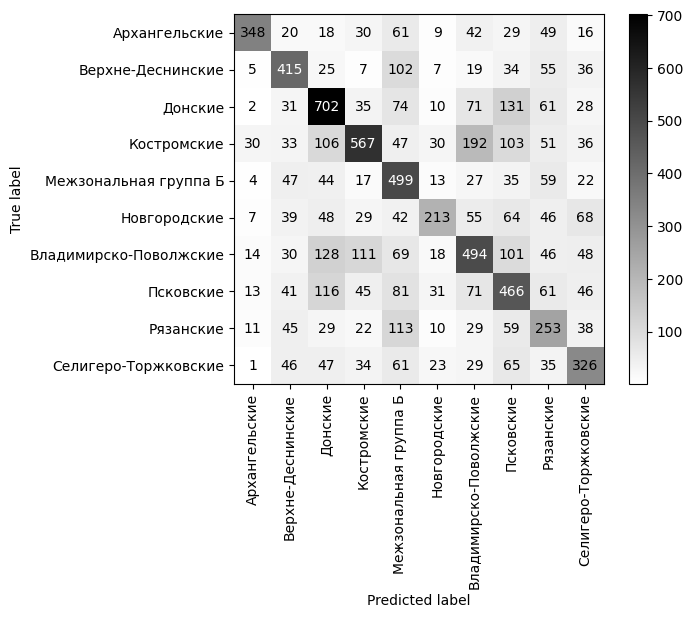

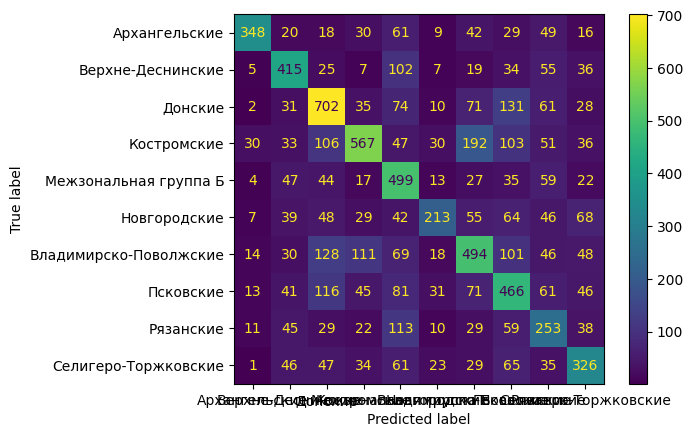

In [ ]:
print(classification_report(torch.stack(targets).cpu(), torch.stack(preds).cpu(), target_names=labs))
disp = ConfusionMatrixDisplay.from_predictions(torch.stack(targets).cpu(), torch.stack(preds).cpu(),
                            display_labels=labs, xticks_rotation='vertical', cmap='binary')
disp.plot()